# STAT306 Project Report
### 
Group A3 (Chris Jung, Justin Lee, Tetiksha Jain, Ayush Vora)


# Introduction

This project aims to analyze wine data to predict the alcohol level of wines based on physicochemical properties. The dataset includes eleven numerical predictors and one categorical predictor (wine color). Our primary goal is to create an accurate model to predict the alcohol level. We will primarily employ multivariate linear regression for our analysis.

## Data Source


The wine quality data for this project is from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/186/wine+quality). It includes two datasets related to red and white "Vinho Verde" wine samples from the north of Portugal. The goal of these datasets is to model wine quality based on physicochemical tests, as described in the reference [Cortez et al., 2009].

## Variables

- Fixed acidity (g/dm³): Concentration of tartaric acid, affecting the wine's taste and preservation.
- Volatile acidity (g/dm³): Concentration of acetic acid, an indicator of wine spoilage.
- Citric acid (g/dm³): Concentration of citric acid, contributing to the wine's freshness.
- Residual sugar (g/dm³): Amount of sugar remaining after fermentation, impacting the sweetness of the wine.
- Chlorides (g/dm³): Concentration of sodium chloride, affecting the wine's saltiness.
- Free sulfur dioxide (mg/dm³): Amount of free sulfur dioxide, used as a preservative.
- Total sulfur dioxide (mg/dm³): Total amount of sulfur dioxide, used for preventing oxidation and maintaining freshness.
- Density (g/cm³): Density of the wine, related to the alcohol and sugar content.
- pH: Measure of the wine's acidity
- Sulphates (g/dm³): Concentration of potassium sulphate, contributing to the wine's sulfur dioxide levels and thus its preservation.
- Alcohol (% vol.): Alcohol content of the wine, expressed as a percentage of volume.
- Color: Categorical variable indicating whether the wine is red or white.
- Quality (score 0-10): Score based on sensory data, indicating the overall quality of the wine.


## Research Question

(TO CHANGE) Can we predict the quality score of Vinho Verde wines based on their physicochemical properties (at least two different properties) and wine color using multivariate linear regression?

# Analysis

## EDA

In [1]:
# Load necessary libraries
# Install ggplot2 if it is not already installed
if (!require(ggplot2)) {
  install.packages("ggplot2")
  library(ggplot2)
} else {
  library(ggplot2)
}
library(tidyverse)
library(leaps)
library(car)

Loading required package: ggplot2

Warning message:
“package ‘stringr’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




In [2]:
# read data and assign colour fields
redwine_data <- read.csv("winequality-red.csv", header = TRUE, sep = ";")
redwine_data$colour <- "red"
whitewine_data <- read.csv("winequality-white.csv", header = TRUE, sep = ";")
whitewine_data$colour <- "white"

# Combine the two datasets and shuffle
combined_wine_data <- rbind(redwine_data, whitewine_data)
wine_data <- combined_wine_data[sample(nrow(combined_wine_data)), ]


head(wine_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,colour
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
2463,6.2,0.28,0.33,1.7,0.029,24,111,0.99000,3.24,0.50,12.1,6,white
2511,6.2,0.33,0.19,5.6,0.042,22,143,0.99425,3.15,0.63,9.9,5,white
2227,7.0,0.32,0.24,6.2,0.048,31,228,0.99570,3.23,0.62,9.4,6,white
526,10.4,0.64,0.24,2.8,0.105,29,53,0.99980,3.24,0.67,9.9,5,red
4291,6.2,0.28,0.27,10.3,0.030,26,108,0.99388,3.20,0.36,10.7,6,white
2986,5.6,0.49,0.13,4.5,0.039,17,116,0.99070,3.42,0.90,13.7,7,white


In [3]:
# Function to calculate min, max, and mean
calculate_statistics <- function(data) {
  numeric_data <- data[sapply(data, is.numeric)]
  stats <- data.frame(
    Min = round(apply(numeric_data, 2, min), 2),
    Max = round(apply(numeric_data, 2, max), 2),
    Mean = round(apply(numeric_data, 2, mean), 2)
  )
  stats$Feature <- rownames(stats)
  rownames(stats) <- NULL
  return(stats)
}

# Calculate statistics for red and white wines
red_stats <- calculate_statistics(redwine_data[ , !(names(redwine_data) %in% c("color"))])
white_stats <- calculate_statistics(whitewine_data[ , !(names(whitewine_data) %in% c("color"))])

# Add units
units <- c(
  "g(tartaric acid)/dm^3", "g(acetic acid)/dm^3", "g/dm^3", "g/dm^3",
  "g(sodium chloride)/dm^3", "mg/dm^3", "mg/dm^3", "g/dm^3", "", 
  "g(potassium sulphate)/dm^3", "% vol", ""
)

# Add units to the statistics tables
red_stats$Unit <- units
white_stats$Unit <- units

# Reorder columns for readability
red_stats <- red_stats[, c("Feature", "Unit", "Min", "Max", "Mean")]
white_stats <- white_stats[, c("Feature", "Unit", "Min", "Max", "Mean")]

# Print the statistics tables for red and white wines
cat("Red Wine Statistics\n")
print(red_stats)

cat("\nWhite Wine Statistics\n")
print(white_stats)

Red Wine Statistics
                Feature                       Unit  Min    Max  Mean
1         fixed.acidity      g(tartaric acid)/dm^3 4.60  15.90  8.32
2      volatile.acidity        g(acetic acid)/dm^3 0.12   1.58  0.53
3           citric.acid                     g/dm^3 0.00   1.00  0.27
4        residual.sugar                     g/dm^3 0.90  15.50  2.54
5             chlorides    g(sodium chloride)/dm^3 0.01   0.61  0.09
6   free.sulfur.dioxide                    mg/dm^3 1.00  72.00 15.87
7  total.sulfur.dioxide                    mg/dm^3 6.00 289.00 46.47
8               density                     g/dm^3 0.99   1.00  1.00
9                    pH                            2.74   4.01  3.31
10            sulphates g(potassium sulphate)/dm^3 0.33   2.00  0.66
11              alcohol                      % vol 8.40  14.90 10.42
12              quality                            3.00   8.00  5.64

White Wine Statistics
                Feature                       Unit  Min    M

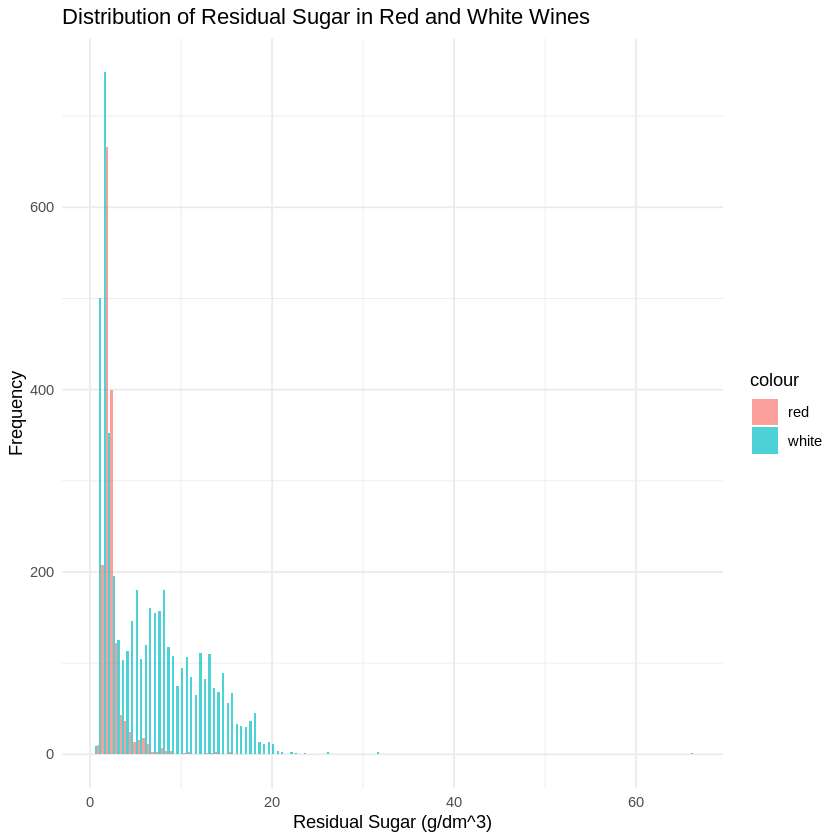

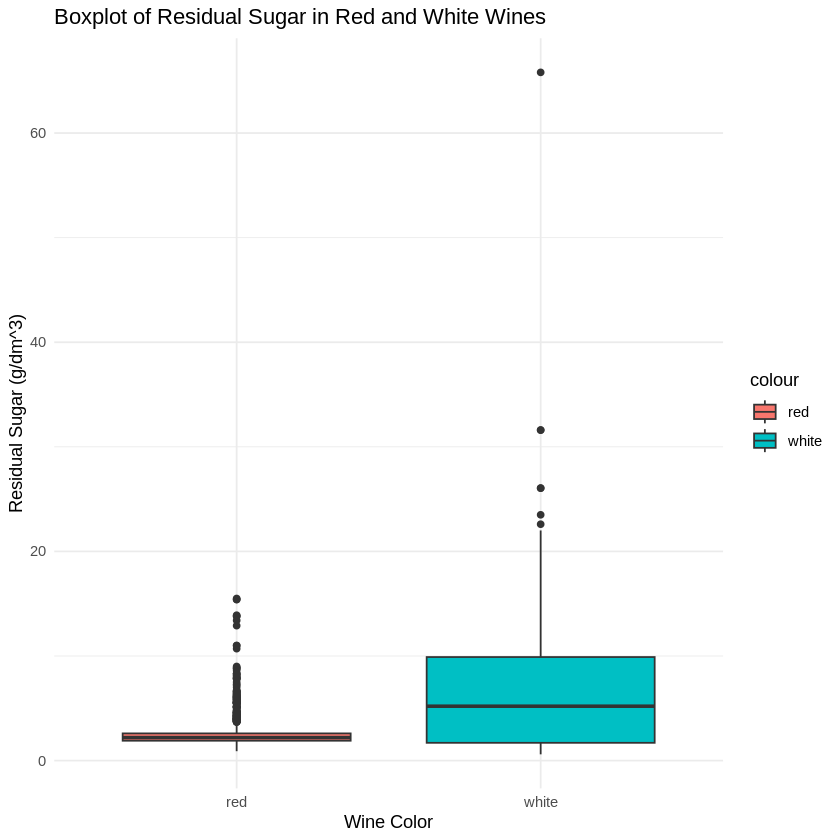

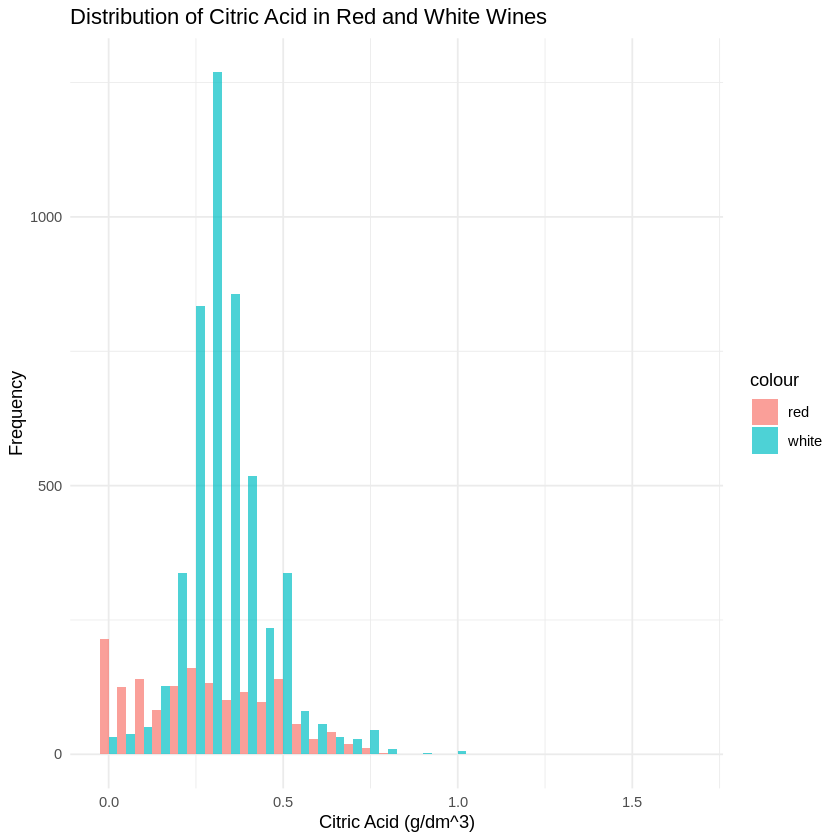

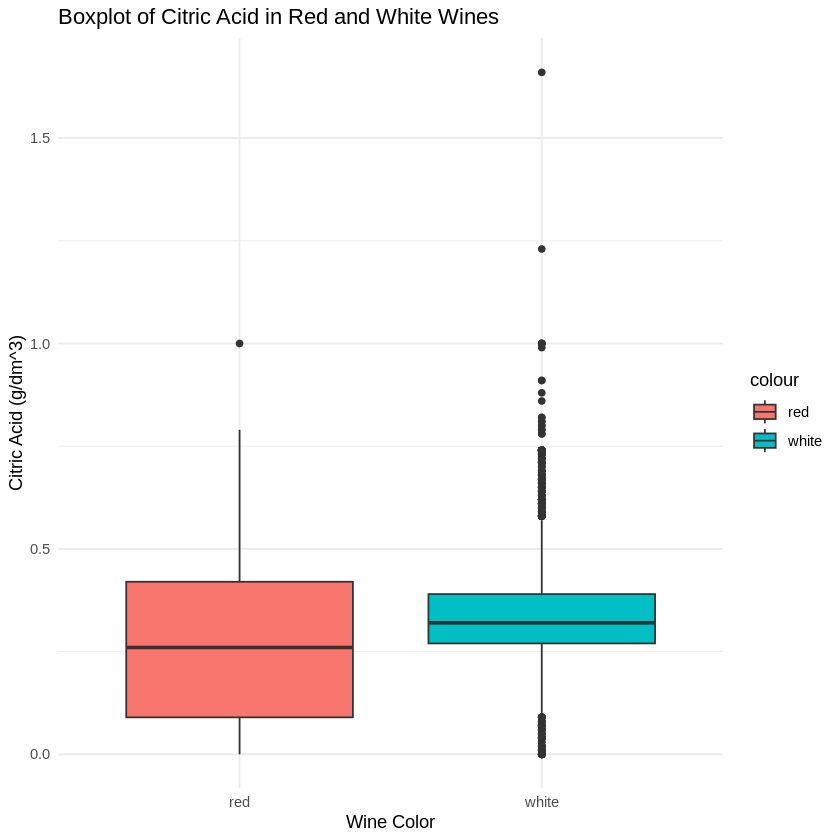

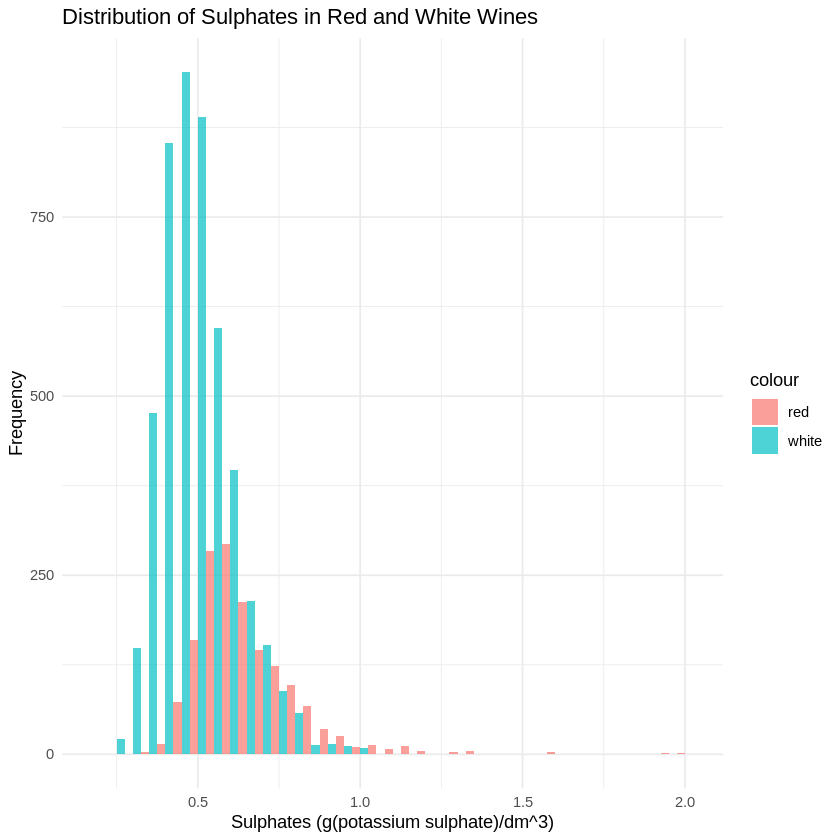

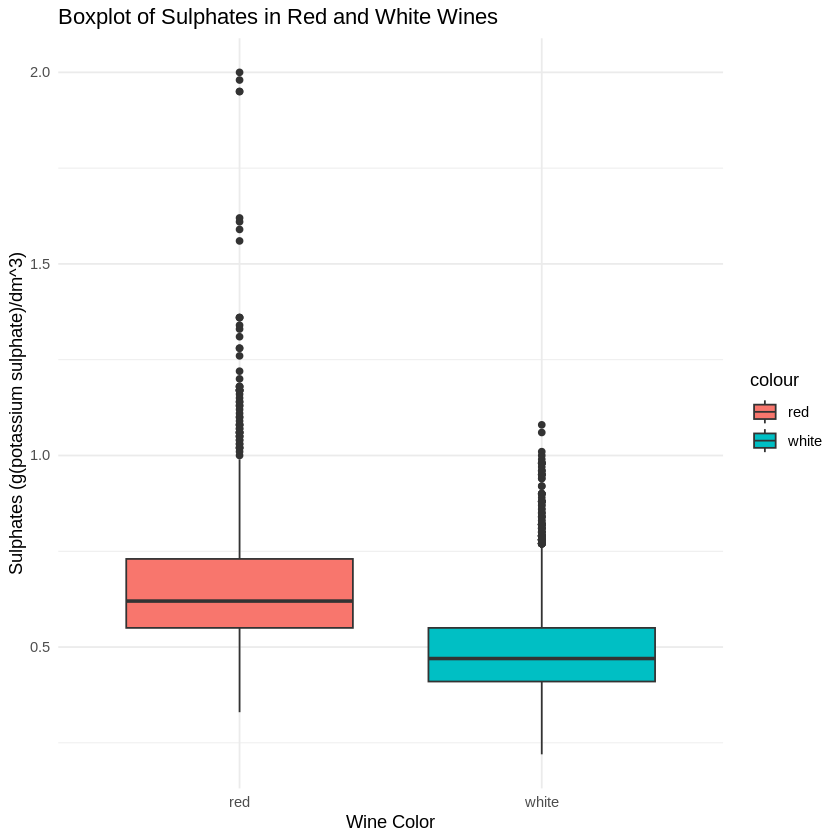

In [4]:
# Histogram for Residual Sugar
ggplot(wine_data, aes(x = residual.sugar, fill = colour)) +
  geom_histogram(binwidth = 0.5, alpha = 0.7, position = "dodge") +
  labs(title = "Distribution of Residual Sugar in Red and White Wines",
       x = "Residual Sugar (g/dm^3)", y = "Frequency") +
  theme_minimal()

# Boxplot for Residual Sugar
ggplot(wine_data, aes(x = colour, y = residual.sugar, fill = colour)) +
  geom_boxplot() +
  labs(title = "Boxplot of Residual Sugar in Red and White Wines",
       x = "Wine Color", y = "Residual Sugar (g/dm^3)") +
  theme_minimal()

# Histogram for Citric Acid
ggplot(wine_data, aes(x = citric.acid, fill = colour)) +
  geom_histogram(binwidth = 0.05, alpha = 0.7, position = "dodge") +
  labs(title = "Distribution of Citric Acid in Red and White Wines",
       x = "Citric Acid (g/dm^3)", y = "Frequency") +
  theme_minimal()

# Boxplot for Citric Acid
ggplot(wine_data, aes(x = colour, y = citric.acid, fill = colour)) +
  geom_boxplot() +
  labs(title = "Boxplot of Citric Acid in Red and White Wines",
       x = "Wine Color", y = "Citric Acid (g/dm^3)") +
  theme_minimal()

# Histogram for Sulphates
ggplot(wine_data, aes(x = sulphates, fill = colour)) +
  geom_histogram(binwidth = 0.05, alpha = 0.7, position = "dodge") +
  labs(title = "Distribution of Sulphates in Red and White Wines",
       x = "Sulphates (g(potassium sulphate)/dm^3)", y = "Frequency") +
  theme_minimal()

# Boxplot for Sulphates
ggplot(wine_data, aes(x = colour, y = sulphates, fill = colour)) +
  geom_boxplot() +
  labs(title = "Boxplot of Sulphates in Red and White Wines",
       x = "Wine Color", y = "Sulphates (g(potassium sulphate)/dm^3)") +
  theme_minimal()


For a linear model, it is preferred to have as few variables as possible, while still having a useful model. This requires striking a good balance for the number of variables, along with the selection of the most important variables for our model. One way we can explore relavent variables is using a correlation heatmap. With this, we can see which variables have a high correlation with each other. Variables that are highly correlated with the response variable are typically important for the model. However, if a model has two variables which are highly correlated to each other, our model could be improved by removing the less important of the two.

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12) 
plot_corr_matrix_wine <- wine_data |>
    subset(select = -c(colour)) |>
    cor() |>
    as_tibble(rownames = 'var1') |>
    pivot_longer(-var1, names_to = "var2", values_to = "corr") |>
    ggplot(aes(x = var1, y = var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n", palette =  "YlGn", direction = 1, limits = c(-1,1)) +
    labs(title = "Correlation Heatmap across Variables", x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")) +
    coord_fixed() +
    geom_text(aes(x = var1, y = var2, label = round(corr, 2)), color = "black", size = 6)

plot_corr_matrix_wine

## Methodology

Our goal is to predict values of the response variable `alcohol` using an additive multiple linear regression (MLR) model with a minimum of three input variables. To select the number of input variables in our model, as well as which input variables to include, we will use a forward selection algorithm. A well-fitting model would have a minimal Mallow's $C_p$ statistic that is also approximately equal to the number of parameters, $p$. We want to select a model that fulfils this condition. After fitting the model, we can assess its efficacy by checking its adjusted coefficient of determination $R^2$. The $R^2$ value is the proportion of variance that the model explains, which implies that this is a measure of goodness-of-fit. When adjusted, this statistic also accounts for the number of parameters in the model to limit the inflation that including more parameters brings.

We will firstly fit a full model to compare to the model fitted with forward selection. We begin by splitting the data into two training/testing sets. We will train the model on our training set and test it by using the model to fit the testing set. Before we fit a reduced model, we must decide which variables to include and exclude; we will use forward selection to find the optimal number of variables and which variables to include. To test the out-of-sample performance of both the model selected via forward selection and the full model, we can check their respective root mean square errors (RMSE).

## Execution

We will start by splitting the dataset into two subsets: Set A will be the training set and set B will be the testing set. 

In [5]:
# splitting data into testing and training sets
set.seed(123)
sample <- sample.int(nrow(wine_data), nrow(wine_data)*0.75, replace = FALSE)

seta <- wine_data[sample,]
setb <- wine_data[-sample,]

Next, we naively fit a full model. With this model, we will be able to test which variables are relavent in our model.

In [6]:
# fitting full model for both sets
full <- lm(alcohol~., seta)

In [7]:
summary(full)


Call:
lm(formula = alcohol ~ ., data = seta)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2922 -0.2963 -0.0343  0.2504 14.6468 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)           6.344e+02  6.202e+00  102.296  < 2e-16 ***
fixed.acidity         5.048e-01  1.023e-02   49.356  < 2e-16 ***
volatile.acidity      8.339e-01  6.607e-02   12.623  < 2e-16 ***
citric.acid           5.539e-01  6.375e-02    8.690  < 2e-16 ***
residual.sugar        2.248e-01  3.431e-03   65.533  < 2e-16 ***
chlorides            -1.144e+00  2.646e-01   -4.324 1.57e-05 ***
free.sulfur.dioxide  -3.805e-03  6.080e-04   -6.258 4.23e-10 ***
total.sulfur.dioxide -4.539e-04  2.563e-04   -1.771   0.0766 .  
density              -6.410e+02  6.341e+00 -101.099  < 2e-16 ***
pH                    2.556e+00  6.249e-02   40.902  < 2e-16 ***
sulphates             1.046e+00  6.120e-02   17.093  < 2e-16 ***
quality               1.061e-01  9.781e-03   10.851  < 2e-16 ***


The variance inflation factor (VIF) of the variables of a model help us find any signs of multicollinearity in a model. A variable with a high VIF could mean that it has a strong correlation with other variables in the model, and can likely be removed without much impact on the model. Below, we can see the VIF of each of the variables.

In [1]:
vif(full_model)

ERROR: Error in vif(full_model): could not find function "vif"


In [8]:
# calculating RMSE
rmse <- function(u,v) sqrt(mean((u-v)^2))

fullpred <- predict(full, setb)
fullrmse <- rmse(fullpred, setb$alcohol)
fullrmse

[1] 0.4624003

We will then run a forward selection to see which, and how many variables are needed for a good model.

In [9]:
# selecting variables
wine_fwd_sel <- regsubsets(alcohol~., wine_data, method = "forward", nvmax = 13)
fwd_sel_sum <- summary(wine_fwd_sel)
fwd_sel_sum_detail <-  tibble(
    n_input_variables = 1:12,
    RSS = fwd_sel_sum$rss,
    BIC = fwd_sel_sum$bic,
    Cp = fwd_sel_sum$cp)

In [10]:
fwd_sel_sum_detail
fwd_sel_sum$which

n_input_variables,RSS,BIC,Cp
<int>,<dbl>,<dbl>,<dbl>
1,4882.744,-4127.126,13200.93137
2,4278.948,-4975.952,10767.59602
3,3371.743,-6515.261,7110.50070
4,2598.100,-8199.923,3992.10577
5,1821.987,-10496.622,863.75315
6,1709.435,-10902.121,411.79010
7,1685.403,-10985.329,316.85853
8,1648.804,-11119.189,171.24129
9,1629.416,-11187.258,95.04408


,(Intercept),fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,quality,colourwhite
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
2,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
3,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
4,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE
5,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE
6,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE
7,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE
8,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE
9,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE
10,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE


Looking at the first table, we can see that the best model is the one with 11 variables. It has the lowest $Cp$ value and has a value that is closest to the number of variables, $p$. Based on the second table, we see that if we were to choose 11 variables, the best model would use all the variables except `total.sulfur.dioxide`. We will now fit a model that omits this variable.

In [11]:
# fitting reduced model for both sets using variables selected above
reduced <- lm(alcohol~.-total.sulfur.dioxide, seta)

In [12]:
summary(reduced)


Call:
lm(formula = alcohol ~ . - total.sulfur.dioxide, data = seta)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3152 -0.2934 -0.0348  0.2499 14.7279 

Coefficients:
                      Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          6.373e+02  5.986e+00  106.472  < 2e-16 ***
fixed.acidity        5.065e-01  1.018e-02   49.745  < 2e-16 ***
volatile.acidity     8.175e-01  6.542e-02   12.495  < 2e-16 ***
citric.acid          5.451e-01  6.356e-02    8.576  < 2e-16 ***
residual.sugar       2.254e-01  3.414e-03   66.021  < 2e-16 ***
chlorides           -1.134e+00  2.646e-01   -4.288 1.84e-05 ***
free.sulfur.dioxide -4.436e-03  4.927e-04   -9.003  < 2e-16 ***
density             -6.440e+02  6.123e+00 -105.165  < 2e-16 ***
pH                   2.559e+00  6.246e-02   40.975  < 2e-16 ***
sulphates            1.038e+00  6.106e-02   17.006  < 2e-16 ***
quality              1.073e-01  9.761e-03   10.994  < 2e-16 ***
colourwhite         -1.110e+00  3.504e-02  -31.676  < 

In [13]:
# calculating RMSE
reducedpred <- predict(reduced, setb)
reducedrmse <- rmse(reducedpred, setb$alcohol)
reducedrmse

[1] 0.4614946

In [14]:
# calculating the difference in RMSE
fullrmse-reducedrmse

[1] -0.0009057673

As we can see, there is a negligible difference between the full model and the reduced model. Becuase, in general, a simpler model with less variables is preferred, we can say our reduced model is better.

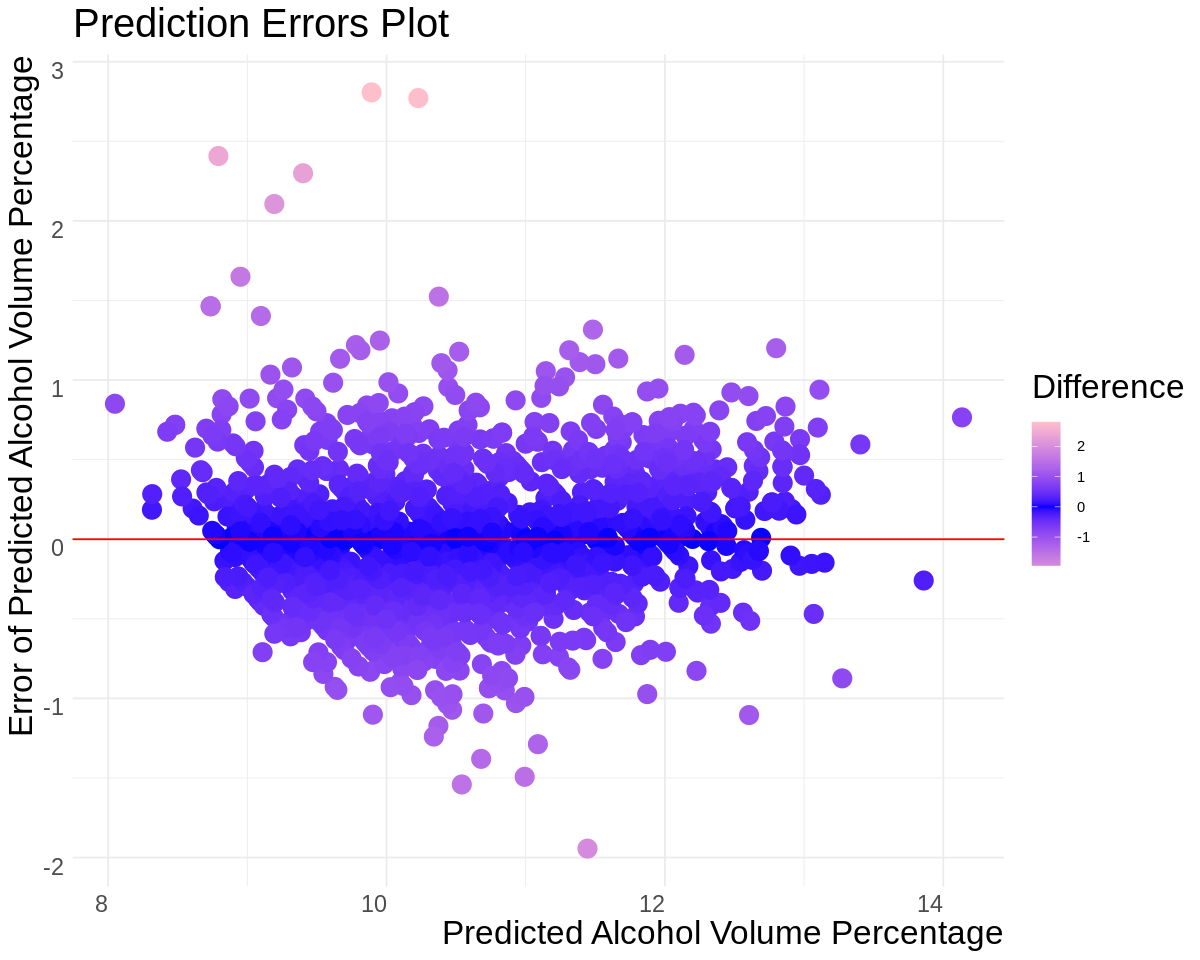

In [18]:
options(repr.plot.width = 10, repr.plot.height = 8)

wine_predict <- predict(reduced, setb)

# plotting an errors plot to observe the nature of the prediction errors produced by our model
comparison <- data.frame(pred = wine_predict, actual = setb$alcohol)
comparison$diffs <- comparison$actual - comparison$pred

errors_plot <- ggplot(comparison, aes(x = pred, y = diffs, colour = diffs)) +
    geom_point(size = 5) +
    geom_hline(yintercept = 0, color = "red") +
    scale_colour_gradient2(low = "pink", high = "pink", mid = "blue", name = "Difference") + 
    theme_minimal() +
    theme(
     axis.text.x = element_text(
         vjust = 1, size = 14, hjust = 1),
     axis.text.y = element_text(
         vjust = 1, size = 14, hjust = 1),
     title = element_text(
         vjust = 1, size = 20, hjust = 1)) +
    labs(
        title = "Prediction Errors Plot",
        x = "Predicted Alcohol Volume Percentage",
        y = "Error of Predicted Alcohol Volume Percentage"
    )
errors_plot

# Conclusion

In this project, we developed and evaluated predictive models for estimating the alcohol percentage in wines based on a range of physicochemical properties. Our approach included building both a full model using all available variables and a reduced model that excluded the least significant variable, total sulfur dioxide, based on forward selection.

The results demonstrated that both models performed relatively well, as indicated by the adjusted R-squared (adjR²) values and the Root Mean Squared Error (RMSE) differences. Interestingly, the reduction in the model's complexity by removing one variable did not significantly degrade the model's performance, suggesting that most predictors contribute meaningfully to the model's predictive power. 

Throughout the analysis, we utilized various visualizations, including histograms and box plots, to better understand the distribution of key variables like residual sugar, citric acid, and sulphates across red and white wines. These plots revealed differences in the distribution and variance of these properties between red and white wines, underscoring the complexity of using a combined dataset for prediction. We also observed that separate models for red and white wines could potentially yield more accurate and tailored predictions, making this an area worth exploring in future analysis.

In summary, our models ...

# References

Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.